# Import Libraries

In [141]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from operator import itemgetter
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
from operator import itemgetter
from nltk.corpus import wordnet
import numpy as np

# Declaring static variables

In [142]:
DATA_INPUT_FILE = 'data\\main.csv'
COLUMN_NAMES = ['name', 'rating', 'date', 'heading', 'review']
DATA_INTER_FILE = 'data\\main_processed.csv'
QUANTILE_CONSIDERATION = 0.9
RATING_SIZE = 5
ONE_GRAM_RESULT_LOCATION = 'results\\oneGram.svg'
BIGRAM_RESULT_LOCATION = 'results\\bigram.svg'
TRIGRAM_RESULT_LOCATION = 'results\\trigram.svg'

# Reading input data

In [143]:
df = pd.read_csv(DATA_INPUT_FILE, header=None, names=COLUMN_NAMES)

# Pre Processing Data
## Transforming the dataset
1. Convert ratings from string to numeric
2. Convert date from string ot datetime
3. Trim and lower heading and review





In [144]:
# Extract numeric ratings from string ratings
df['rating_num'] = df['rating'].str.split(" ").str[0].astype(float)

# Extract date from string date
df['date_dt'] = pd.to_datetime(df['date'], format="%m/%d/%y")

# Format heading and review columns to homogenize data
df['heading'] = df['heading'].str.lower()
df['heading'] = df['heading'].str.strip()
df['review'] = df['review'].str.lower()
df['review'] = df['review'].str.strip()

# Creating new column that stores number of words in heading and review
df['heading_len'] = df['heading'].str.count(' ') + 1
df['review_len'] = df['review'].str.count(' ') + 1

# Exploratory Data Analysis

## Exploring the dataset

In [145]:
df.head()

name           rating      date  \
0     Dane C.  5.0 star rating  12/22/21   
1    Julie M.  5.0 star rating  12/22/21   
2    Nolan I.  5.0 star rating  12/22/21   
3   Edward S.  5.0 star rating  12/22/21   
4  Rosario M.  5.0 star rating  12/22/21   

                                             heading  \
0  transformative, honestly. was skeptical at fir...   
1                                        my thoughts   
2                   rectified issue in timely manner   
3                                    athletic greens   
4                                              great   

                                              review  rating_num    date_dt  \
0  as an athlete who is two months into an ag1 su...         5.0 2021-12-22   
1  i love athletic greens, especially after 90 mi...         5.0 2021-12-22   
2                                   good job on that         5.0 2021-12-22   
3  love you’re guys stuff. service is fantastic s...         5.0 2021-12-22   
4  i feel better, sleep better, focus better, ove...         5.0 2021-12-22   

   heading_len  review_len  
0           10          66  
1            2          32  
2            5           4  
3            2          13  
4            1          25

Text(0, 0.5, 'Count of reviews')

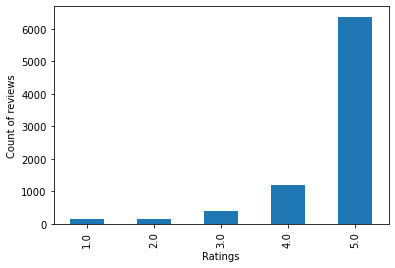

In [146]:
# Plot count of ratings
grouped = df[['rating_num', 'name']].groupby(by='rating_num').count()
grouped.plot.bar(legend=False)
plt.xlabel('Ratings')
plt.ylabel('Count of reviews')

Text(0, 0.5, 'Count of reviews')

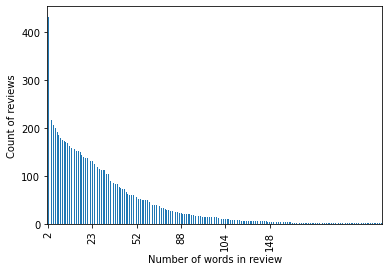

In [147]:
# Plot length of ratings
grouped = df[['name', 'review_len']].groupby(by='review_len').count()
grouped.sort_values(by='name', ascending=False, inplace=True)
grouped.plot.bar(legend=False)
plt.xticks(np.arange(0, 150, step=25))
plt.xlabel('Number of words in review')
plt.ylabel('Count of reviews')

# Processing Data 

## Data Preparation
1. Excluding 10 percentile long reviews

In [148]:
# Excluding reviews that are longer than 90 percentile of all reviews
r_grouped = df[['review_len', 'name']].groupby(by='review_len')
df_r_g = r_grouped.count()
review_len_limit = df_r_g.quantile(QUANTILE_CONSIDERATION).iloc[0]

df = df[(df['review_len']<= review_len_limit)]

## Data Cleaning
1. Removing email id's phone numbers, urls, punctutations, and emojis from headings and reviews.
2. Tokenization and removing stop words

In [149]:
# Removing email id's phone numbers, urls, punctutations, and emojis from headings and reviews.

# Creating a pattern for emojis
emoji_pattern = re.compile(pattern = "["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "]+", flags = re.UNICODE)

REGEX_DICT = {
    'REGEX_EMAIL' : r'-*@-*', # Identify emails
    'REGEX_URL' : r'-*\.com-*', # Identify URLs
    'REGEX_PHONENUMBER' :  r'\b\d{10}\b', # Identify phone numbers
    "REGEX_PUNCTUATIONS" : r'[^a-z0-9 ]+', # Identify punctuations
    "REGEX_EMOJI" : emoji_pattern # Identify emojis
    
}

# Applying the filters
df[['heading_clean', 'review_clean']] = df[['heading', 'review']]
for key, val in REGEX_DICT.items(): 
    df[['heading_clean', 'review_clean']] = df[['heading_clean', 'review_clean']].replace(val, '', regex=True)

# Tokenization and removing stop words
stopWords = stopwords.words('english') # Importing standard english stop words
# Adding athletic and greens to stop words since most reviews include this
stopWords.extend(['athletic', 'green', 'greens']) 
stopWords = [x.lower() for x in stopWords] # transforming stop words to lower case
# Removing puncutations from stop words
stopWords = [re.sub(REGEX_DICT['REGEX_PUNCTUATIONS'], '', x) for x in stopWords]
# Initializing lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clean_tokenization(text):
    return word_tokenize(text)

def clean_stopwords(token):
    return [item for item in token if item not in stopWords]

def lemmatize_list(list_words):
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in list_words]

# Tokenizing text data
df['heading_clean'] = df['heading_clean'].apply(clean_tokenization)
df['review_clean'] = df['review_clean'].apply(clean_tokenization)

# Removing stop words from text 
df['heading_clean'] = df['heading_clean'].apply(clean_stopwords)
df['review_clean'] = df['review_clean'].apply(clean_stopwords)

# Lemmatizing text
df['heading_clean'] = df['heading_clean'].apply(lemmatize_list)
df['review_clean'] = df['review_clean'].apply(lemmatize_list)


## Explore top tokens by Rating

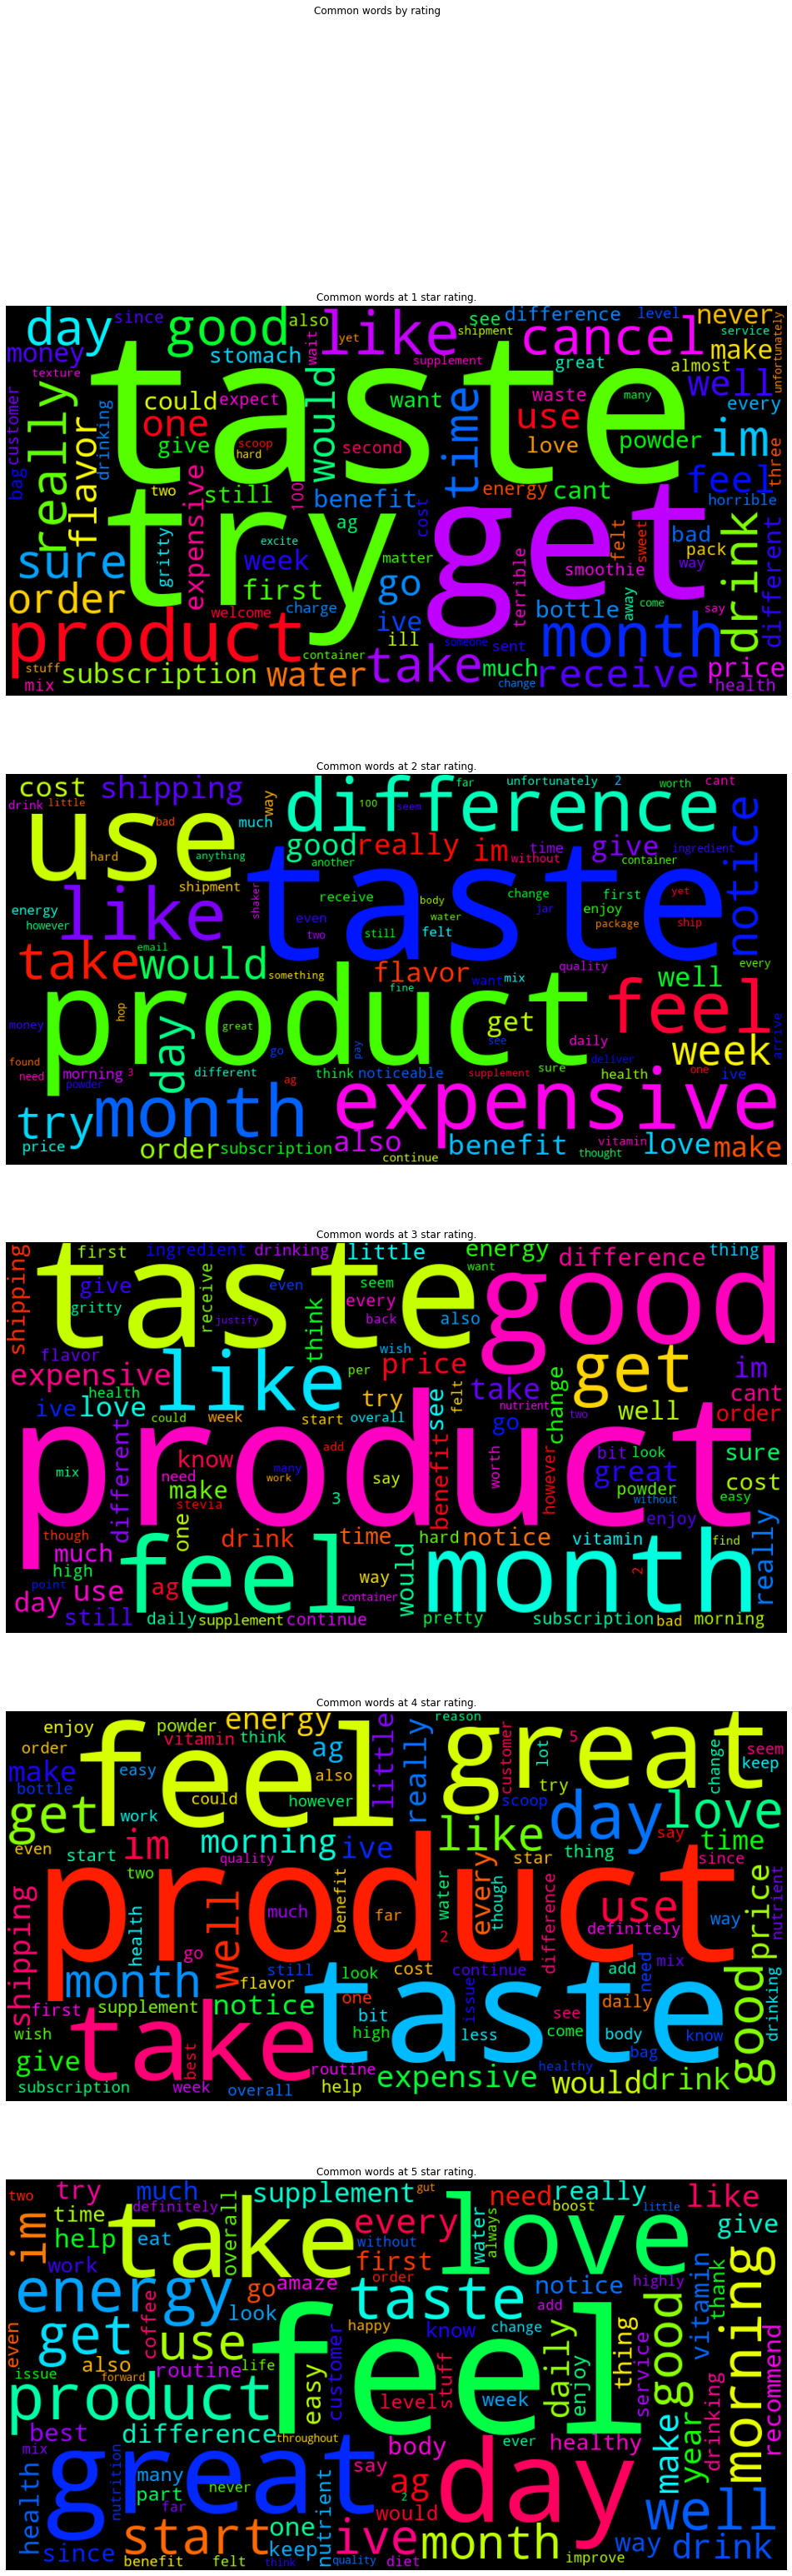

In [150]:
def get_ListWords(df):
    """Returns a list of all words post cleaning from the 'review_clean' column of the dataframe"""
    list_w = []
    for index, row in df.iterrows():
        for item in row['review_clean']:
            list_w.append(item) 
    return list_w


def get_oneGramWordCloud(df):
    """Returns a wordcloud of 100 most common tokens in 'review_clean' column of the dataframe passed"""

    list_words = get_ListWords(df) # Tokenize words in reviews
    dictionary=Counter(list_words) # Rank and count tokens
    
    # Setting up word cloud
    WC_height = 500 # Height of wordcloud
    WC_width = 1000 # Width of wordcloud
    WC_max_words = 100 # Max number of words in wordcloud
    cloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width,colormap="hsv").generate_from_frequencies(dictionary)
    return cloud



fig, axs = plt.subplots(RATING_SIZE, figsize=(25, 50))
fig.suptitle('Common words by rating')
for i in range(RATING_SIZE):
    cloud = get_oneGramWordCloud(df[df['rating_num']==(i+1)])
    axs[i].imshow(cloud, interpolation='bilinear')
    axs[i].title.set_text('Common words at {} star rating.'.format(i+1))
    axs[i].axis('off')
fig.savefig(ONE_GRAM_RESULT_LOCATION, dpi=300)
    

## Explore top bigrams by rating

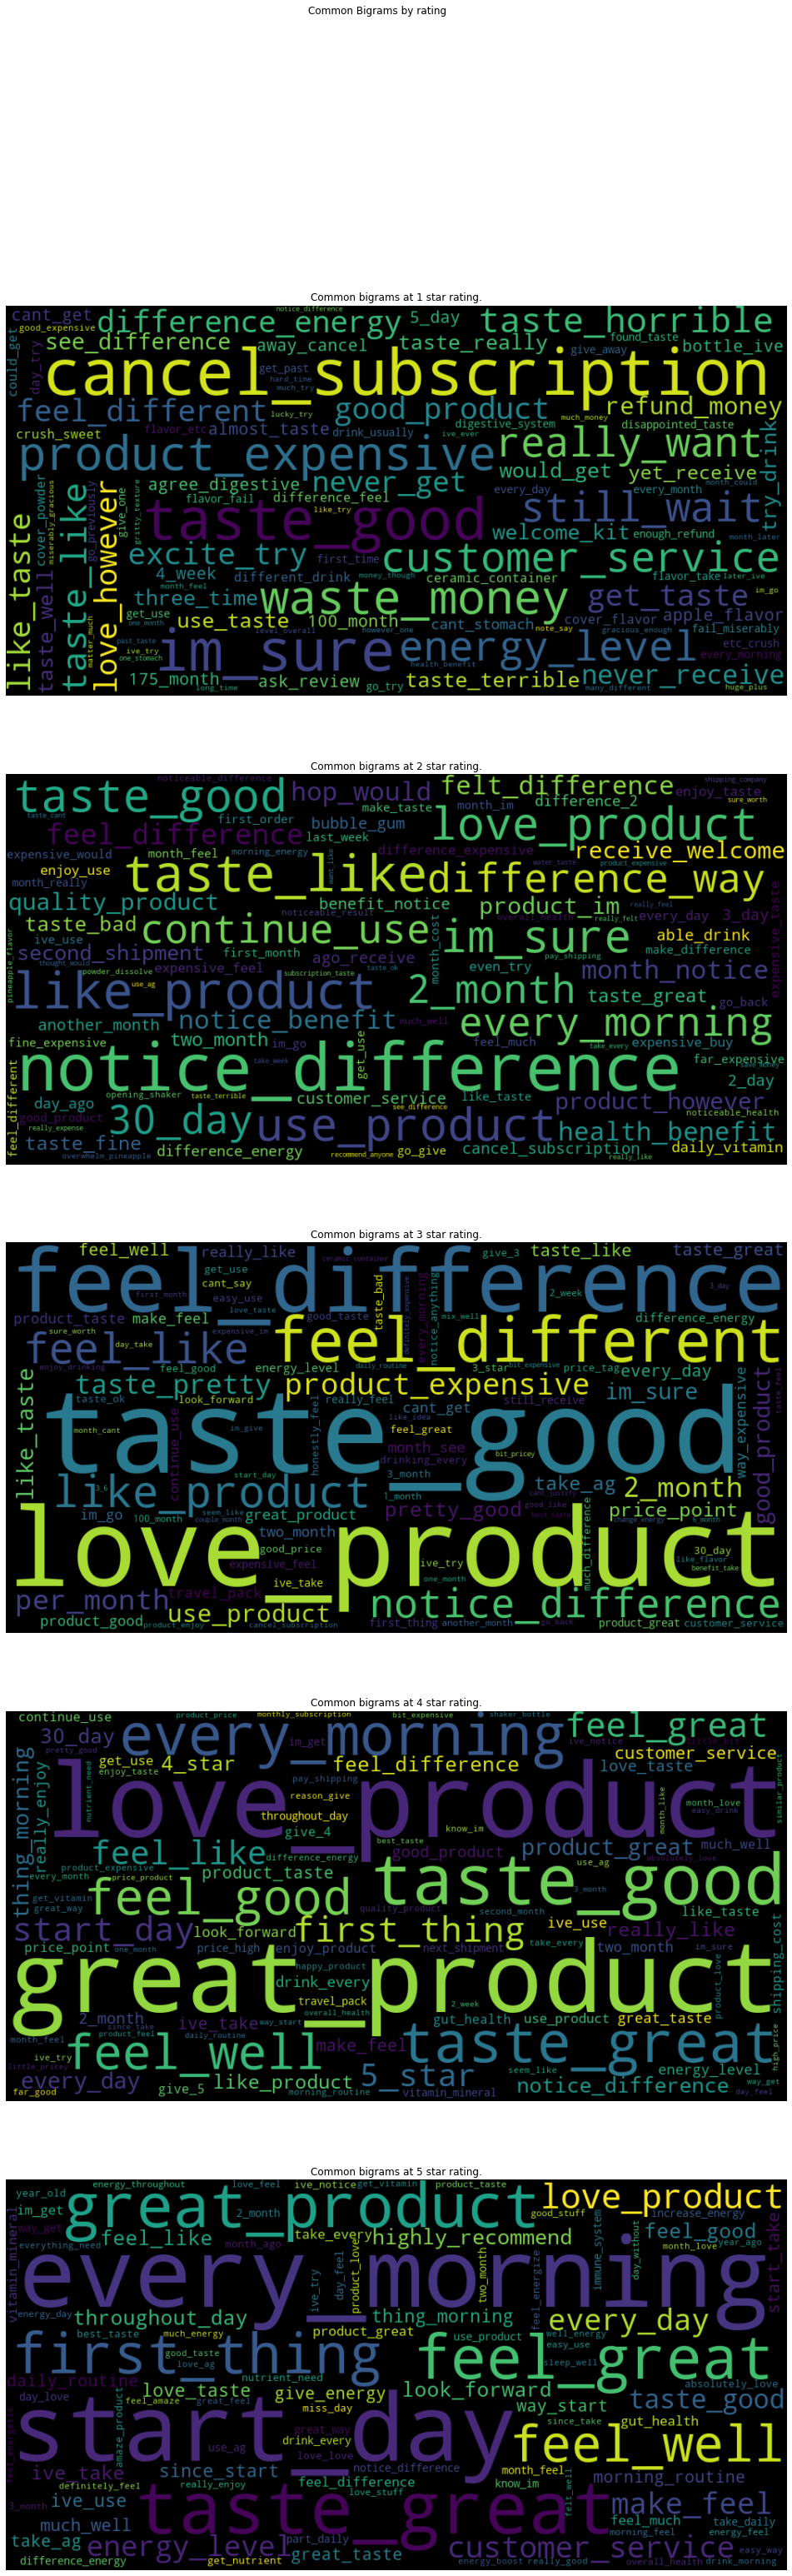

In [151]:
def get_bigramWordCloud(df):
    list_words = get_ListWords(df)

    # setup and score the bigrams using the raw frequency.
    finder = BigramCollocationFinder.from_words(list_words)
    bigram_measures = BigramAssocMeasures()
    scored = finder.score_ngrams(bigram_measures.raw_freq)

    scoredList = sorted(scored, key=itemgetter(1), reverse=True)

    word_dict = {}
    
    listLen = len(scoredList)
    # Get the bigram and make a contiguous string for the dictionary key.
    # Set the key to the scored value.
    for i in range(listLen):
        word_dict['_'.join(scoredList[i][0])] = scoredList[i][1]
    
    
    # Set word cloud params and instantiate the word cloud.
    # The height and width only affect the output image file.
    WC_height = 500
    WC_width = 1000
    WC_max_words = 100
 
    wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width).generate_from_frequencies(word_dict)
    
    return wordCloud


fig, axs = plt.subplots(RATING_SIZE, figsize=(25, 50))
fig.suptitle('Common Bigrams by rating')
for i in range(RATING_SIZE):
    cloud = get_bigramWordCloud(df[df['rating_num']==(i+1)])
    axs[i].imshow(cloud, interpolation='bilinear')
    axs[i].title.set_text('Common bigrams at {} star rating.'.format(i+1))
    axs[i].axis('off')
fig.savefig(BIGRAM_RESULT_LOCATION, dpi=300)

## Explore top trigrams by rating

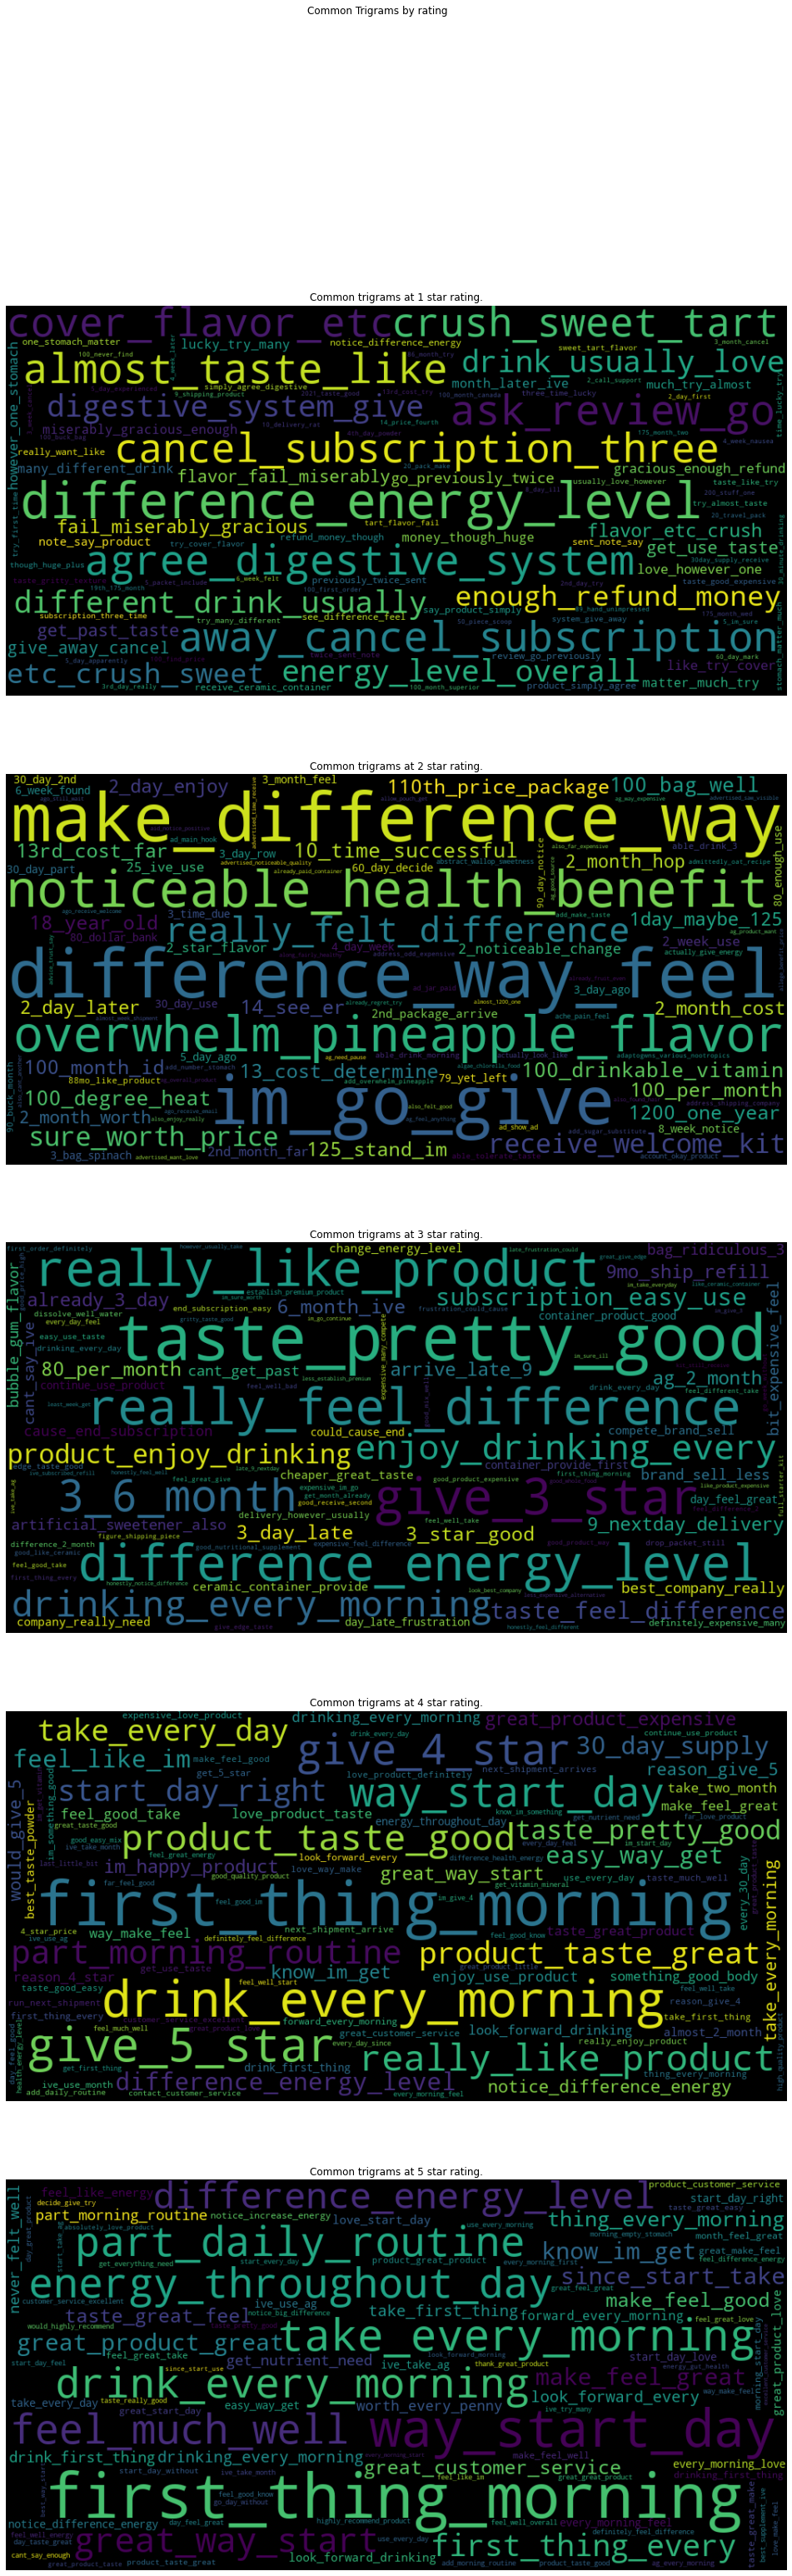

In [152]:
def get_trigramWordCloud(df):
    list_words = get_ListWords(df)

    # setup and score the bigrams using the raw frequency.
    finder = TrigramCollocationFinder.from_words(list_words)
    trigram_measures = TrigramAssocMeasures()
    scored = finder.score_ngrams(trigram_measures.raw_freq)

    scoredList = sorted(scored, key=itemgetter(1), reverse=True)

    word_dict = {}
    
    listLen = len(scoredList)
    # Get the bigram and make a contiguous string for the dictionary key.
    # Set the key to the scored value.
    for i in range(listLen):
        word_dict['_'.join(scoredList[i][0])] = scoredList[i][1]
        
    # Set word cloud params and instantiate the word cloud.
    # The height and width only affect the output image file.
    WC_height = 500
    WC_width = 1000
    WC_max_words = 100
 
    wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width).generate_from_frequencies(word_dict)

    return wordCloud



fig, axs = plt.subplots(RATING_SIZE, figsize=(25, 50))
fig.suptitle('Common Trigrams by rating')
for i in range(RATING_SIZE):
    cloud = get_trigramWordCloud(df[df['rating_num']==(i+1)])
    axs[i].imshow(cloud, interpolation='bilinear')
    axs[i].title.set_text('Common trigrams at {} star rating.'.format(i+1))
    axs[i].axis('off')
fig.savefig(TRIGRAM_RESULT_LOCATION, dpi=300)

In [153]:
df.to_csv(DATA_INTER_FILE)